In [38]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import xarray as xr
import dask
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
from keras.layers import BatchNormalization
import tensorflow_probability as tfp
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model

In [39]:
cd ../../../icme-xplore-bayes-spring22/src/data

/home/misbah/Desktop/CS 229/Project/icme-xplore-bayes-spring22/src/data


In [40]:
rm -rf trials

In [41]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks=1)
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']

In [42]:
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks=1)
Y_obs = dataset_obs['SWCF']
Y_scalar=Y_obs.values.var()
Y_shift=Y_obs.values.mean()
Y_np = (Y.values-Y_obs.values)/np.sqrt(Y_scalar)
Y_np = np.array([Yi.flatten() for Yi in Y_np])

In [43]:
X_np = X.values
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


In [129]:
index=np.random.choice(250,50)
X_test=X[index]
Y_test=Y[index]
Index_x_bool=np.array([True]*250)
Index_x_bool[index]=False
X_train=X[Index_x_bool]
Y_train=Y[Index_x_bool]

Text(0.5, 1.0, 'Cumulative explained ratio')

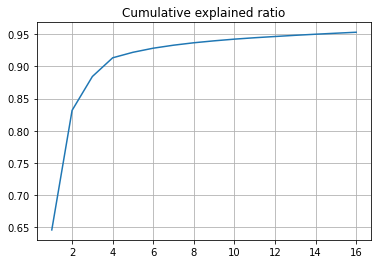

In [166]:
# Re-label the data to X and Y
X = X_s.copy()
Y = Y_np.copy()

# Import PCA transform from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=16,whiten=True)
Yhat = pca.fit_transform(Y)

# We can plot the explained variance which shows how much of the total variance the PCA components capture
import matplotlib.pyplot as plt
evr = pca.explained_variance_ratio_
plt.plot(range(1,len(evr)+1),np.cumsum(evr))
plt.grid(True)
plt.title("Cumulative explained ratio")

In [201]:
U,S,Vt = pca._fit((Y-np.mean(Y,axis=0)))
((U[:,:16] * S[:16]) - pca.transform(Y-np.mean(Y,axis=0))).shape
Y.shape

(250, 1152)

In [189]:
Vt - pca.components_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [206]:
1e-4 * .9**1000

1.7478712517226948e-50

In [167]:
Y_train2=Yhat[Index_x_bool]
Y_test2=Yhat[index]

array([[ 4.2970777e-03,  7.2415322e-03,  6.0580522e-03, ...,
        -3.0850060e-08,  1.1851080e-07,  6.5774657e-08],
       [ 2.9917657e-03,  3.6402643e-03,  4.9184859e-03, ...,
        -8.0186874e-07, -2.7008355e-07, -7.3341653e-09],
       [-3.7835389e-03, -1.7596930e-03, -7.5975060e-04, ...,
        -3.2363459e-08,  1.9243453e-07,  4.1909516e-08],
       ...,
       [ 3.3397749e-03,  2.0772517e-03,  1.4308691e-03, ...,
         4.8521906e-07,  7.6950528e-08,  1.3271347e-08],
       [-2.1607876e-03, -3.6940873e-03, -4.7513694e-03, ...,
         1.7194543e-07,  9.9069439e-08,  3.7951395e-08],
       [-8.4083229e-03, -5.6344569e-03, -3.4313649e-03, ...,
        -2.0593870e-07,  4.6216883e-08,  6.7870133e-08]], dtype=float32)

In [115]:
def custom_loss(y_actual,y_pred):
    print('AAA: ', kb.shape(y_actual))
    err = y_actual-y_pred
    z = kb.zeros(24*48)
    z = 
    #z = kb.exp(-np.abs(np.arange(24, dtype=float)-11.5)) + 1e-15
    
    #weights = z/np.sum(z)
    #custom_loss= np.mean(err**2 * np.reshape(weights,(-1,1)))**.5
    #custom_loss = kb.square(kb.flatten(err))
    return custom_loss

In [116]:
K = np.ones(1152)
L = np.zeros(1152)
print(custom_loss(K,L))
K[48*12:48*13] = 0
print(custom_loss(K,L))
K[48*12:48*13] = 1
K[:48] = 0
print(custom_loss(K,L))

AAA:  tf.Tensor([1152], shape=(1,), dtype=int32)
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(1152,), dtype=float64)
AAA:  tf.Tensor([1152], shape=(1,), dtype=int32)
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(1152,), dtype=float64)
AAA:  tf.Tensor([1152], shape=(1,), dtype=int32)
tf.Tensor([0. 0. 0. ... 1. 1. 1.], shape=(1152,), dtype=float64)


In [117]:
def build_model_PCA(hp):
    model = keras.Sequential()
    model.add(keras.layers.BatchNormalization(input_shape=(5,)))
    model.add(tf.keras.layers.Flatten())
    model.add(keras.layers.Dense(
    units=hp.Int("units", min_value=1, max_value=40, step=10),
    activation="leaky_relu"
    #,kernel_regularizer =tf.keras.regularizers.l2( l=hp.choice("regularizer", values=[0,.001,.0001]))
    )
    )
#     if hp.Boolean("dropout"):
#         model.add(keras.layers.Dropout(rate=0.25))
        
    model.add(keras.layers.Dense(
    units=hp.Int("units2", min_value=1, max_value=40, step=10),
    activation="leaky_relu"
    #,kernel_regularizer =tf.keras.regularizers.l2( l=hp.choice("regularizer", values=[0,.001,.0001]))
    ))
    model.add(keras.layers.Dense(
    units=hp.Int("units3", min_value=100, max_value=140, step=10),
    activation="leaky_relu"
    #,kernel_regularizer =tf.keras.regularizers.l2( l=hp.choice("regularizer", values=[0,.001,.0001]))
    ))
    model.add(keras.layers.Dense(16, activation='leaky_relu'))
    hp_learning_rate=hp.Choice("learning_rate",values=[2e-2,5e-2])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),loss=custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
    return model

In [118]:
tuner = kt.Hyperband(
    build_model_PCA,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    overwrite=True,
    directory='trials',)

In [121]:
tuner.search(X_train, Y_train2, epochs=50, validation_data=(X_test, Y_test2))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
21                |?                 |units
21                |?                 |units2
120               |?                 |units3
0.05              |?                 |learning_rate
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
4                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2
AAA:  Tensor("custom_loss/Shape:0", shape=(2,), dtype=int32)
AAA:  Tensor("custom_loss/Shape:0", shape=(2,), dtype=int32)


InvalidArgumentError:  Input to reshape is a tensor with 512 values, but the requested shape has 1152
	 [[node custom_loss/Reshape (defined at <ipython-input-115-ca46c15aaf58>:3) ]] [Op:__inference_train_function_33432]

Errors may have originated from an input operation.
Input Source operations connected to node custom_loss/Reshape:
 IteratorGetNext (defined at /home/misbah/anaconda3/envs/proj-env/lib/python3.6/site-packages/keras_tuner/engine/hypermodel.py:137)

Function call stack:
train_function


In [44]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 5)                 20        
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 110)               1210      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1776      
Total params: 3,176
Trainable params: 3,166
Non-trainable params: 10
_____________________________________________________

In [75]:
best_params = tuner.get_best_hyperparameters()
print(best_params[0].get('learning_rate'))
print(best_params[0].get('units'))
print(best_params[0].get('units2'))
print(best_params[0].get('units3'))

0.005
10
10
110


In [87]:
best_model = tuner.hypermodel.build(best_params[0])
history = best_model.fit(X_train, Y_train2, epochs=1000)

Epoch 1/1000
7/7 [==============================] - 1s 7ms/step - loss: 0.9990 - root_mean_squared_error: 0.9995
Epoch 2/1000
7/7 [==============================] - 1s 111ms/step - loss: 0.9431 - root_mean_squared_error: 0.9711
Epoch 3/1000
7/7 [==============================] - 1s 109ms/step - loss: 0.9113 - root_mean_squared_error: 0.9546
Epoch 4/1000
7/7 [==============================] - 0s 43ms/step - loss: 0.8941 - root_mean_squared_error: 0.9456
Epoch 5/1000
7/7 [==============================] - 1s 46ms/step - loss: 0.8694 - root_mean_squared_error: 0.9324
Epoch 6/1000
7/7 [==============================] - 1s 84ms/step - loss: 0.8454 - root_mean_squared_error: 0.9195
Epoch 7/1000
7/7 [==============================] - 1s 82ms/step - loss: 0.8251 - root_mean_squared_error: 0.9084
Epoch 8/1000
7/7 [==============================] - 1s 77ms/step - loss: 0.8053 - root_mean_squared_error: 0.8974
Epoch 9/1000
7/7 [==============================] - 1s 54ms/step - loss: 0.7964 - root_

KeyboardInterrupt: 

In [52]:
Y_Pred=best_model.predict(X_test)
Y_Pred_train=best_model.predict(X_train)

In [53]:
Y_orig_test=pca.inverse_transform(Y_Pred)
Y_test2=Y[index]
Y_orig_train=pca.inverse_transform(Y_Pred_train)
Y_train2=Y[Index_x_bool]

In [82]:
Y_train2.shape

(203, 1152)

In [55]:
mse=np.mean(np.square(Y_orig_test-Y_test2))
mse_train = np.mean(np.square(Y_orig_train-Y_train2))

In [56]:
rmse=np.sqrt(mse)
rmse_train = np.sqrt(mse_train)

In [57]:
print("mse is:",mse,"rmse:",rmse)
print("train: ")
print("mse is:",mse_train,"rmse:",rmse_train)

mse is: 0.005830997 rmse: 0.07636096
train: 
mse is: 0.0056804614 rmse: 0.07536884


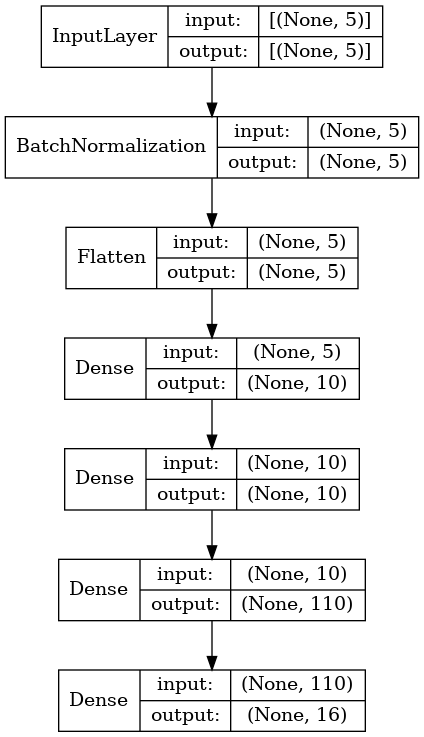

In [50]:
plot_model(best_model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)